# Predicting the NBA All-Stars with Machine Learning

The goal of this analysis is to predict the NBA All-Stars for a given year, based on NBA player data and All-Star selections in other years. This is accomplished by applying several machine learning classification algorithms on NBA player performance data. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA player data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel, MyCM

import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn as sns
import sys

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition import PCA
from sklearn.mixture       import GaussianMixture
from sklearn.cluster       import KMeans, SpectralClustering

from sklearn.linear_model          import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.svm                   import LinearSVC #, SVC
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble              import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble              import BaggingClassifier, VotingClassifier
from sklearn.neural_network        import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #, QuadraticDiscriminantAnalysis
#from sklearn.naive_bayes           import GaussianNB
#from sklearn.gaussian_process      import GaussianProcessClassifier

from sklearn.model_selection import cross_validate, LeaveOneGroupOut

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## User input

Choose the year you want to use to run some validation tests (*validation_year*) and the year you want to predict (*prediction_year*), both in range 2000-2018. The years that are not selected for validation tests and prediction are used to train the model.

In [2]:
validation_year = 2017 # Enter any year from 2000 until 2018
prediction_year = 2018 # Enter any year from 2000 until 2018

print("--> Validation_year = {}".format(validation_year))
print("--> Prediction_year = {}".format(prediction_year))

first_year = 2000 # First year for which data has been scraped
last_year  = 2018 # Last  year for which data has been scraped

training_years = list(range(first_year, last_year+1))

training_years.remove(validation_year)
training_years.remove(prediction_year)

first_training_year = training_years[0]
last_training_year  = training_years[-1]
    
if (first_training_year < validation_year < last_training_year) and (first_training_year < prediction_year < last_training_year):
    print("--> Training years  = {}-{} except {} and {}".format(first_training_year, last_training_year, validation_year, prediction_year))
elif (first_training_year < validation_year < last_training_year):
    print("--> Training years  = {}-{} except {}".format(first_training_year, last_training_year, validation_year))
elif (first_training_year < prediction_year < last_training_year):
    print("--> Training years  = {}-{} except {}".format(first_training_year, last_training_year, prediction_year))
else:
    print("--> Training years  = {}-{}".format(first_training_year, last_training_year))

--> Validation_year = 2017
--> Prediction_year = 2018
--> Training years  = 2000-2016


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not,
and choose the minimum number of games a player has to have played per season to be included in the analysis:

In [3]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")
    
min_num_games = 20 # Enter any number between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Advanced statistics included
--> Minimum number of games for each player = 20


## Load NBA player data:

NBA player data from 2000-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions (*NBA_totals_scraper*, *NBA_advanced_scraper* and *NBA_AllStar_scraper*) in [NBAanalysissetup.py](NBAanalysissetup.py).

In [4]:
df_training, df_validation, df_prediction = \
NBAanalysissetup.loaddata_allyears(prediction_year, validation_year, training_years, includeadvancedstats)

--> Loading   training year 1999-2000 ...
--> Loading   training year 2000-2001 ...
--> Loading   training year 2001-2002 ...
--> Loading   training year 2002-2003 ...
--> Loading   training year 2003-2004 ...
--> Loading   training year 2004-2005 ...
--> Loading   training year 2005-2006 ...
--> Loading   training year 2006-2007 ...
--> Loading   training year 2007-2008 ...
--> Loading   training year 2008-2009 ...
--> Loading   training year 2009-2010 ...
--> Loading   training year 2010-2011 ...
--> Loading   training year 2011-2012 ...
--> Loading   training year 2012-2013 ...
--> Loading   training year 2013-2014 ...
--> Loading   training year 2014-2015 ...
--> Loading   training year 2015-2016 ...
--> Loading validation year 2016-2017 ...
--> Loading prediction year 2017-2018 ...


Print table of All-Stars in *prediction_year*:

Print table of non-All-Stars in *prediction_year*:

Select only players which have played at least *min_num_games* number of games in a season:

In [5]:
print("--> # of players in   training set =", df_training  .shape[0])
print("--> # of players in validation set =", df_validation.shape[0])
print("--> # of players in prediction set =", df_prediction.shape[0])
print("")

df_training   = df_training  [df_training  ['G'] >= min_num_games]
df_validation = df_validation[df_validation['G'] >= min_num_games]
df_prediction = df_prediction[df_prediction['G'] >= min_num_games]

print("--> # of players in   training set =", df_training  .shape[0])
print("--> # of players in validation set =", df_validation.shape[0])
print("--> # of players in prediction set =", df_prediction.shape[0])

# Reset dataframe indices:

df_training   = df_training.  reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_prediction = df_prediction.reset_index(drop=True)

--> # of players in   training set = 7754
--> # of players in validation set = 486
--> # of players in prediction set = 531

--> # of players in   training set = 6669
--> # of players in validation set = 413
--> # of players in prediction set = 400


NaN handling:

In [6]:
print("--> # of players with NaNs in   training set =", df_training  .shape[0] - df_training  .dropna().shape[0])
print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])
print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_training  [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_training  [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_validation[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_validation[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_prediction[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_prediction[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_training  [['TS%', '3PAr', 'FTr']] = df_training  [['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_validation[['TS%', '3PAr', 'FTr']] = df_validation[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_prediction[['TS%', '3PAr', 'FTr']] = df_prediction[['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in   training set =", df_training  .shape[0] - df_training  .dropna().shape[0])
print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])
print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0])
print("")

# Remove remaining players with NaNs, if necessary:

if (df_training.shape[0] - df_training.dropna().shape[0] != 0):
    #print("--> Players in training set with NaNs:")
    #print(df_training[df_training.isnull().any(axis=1)])
    #print("")
    df_training.dropna(inplace=True)
    print("--> # of players with NaNs in   training set =", df_training.shape[0] - df_training.dropna().shape[0])

if (df_validation.shape[0] - df_validation.dropna().shape[0] != 0):
    #print("--> Players in validation set with NaNs:")
    #print(df_validation[df_validation.isnull().any(axis=1)])
    #print("")
    df_validation.dropna(inplace=True)
    print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])

if (df_prediction.shape[0] - df_prediction.dropna().shape[0] != 0):
    #print("--> Players in prediction set with NaNs:")
    #print(df_prediction[df_prediction.isnull().any(axis=1)])
    #print("")
    df_prediction.dropna(inplace=True)
    print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0])
    
# Reset dataframe indices:

df_training   = df_training.  reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_prediction = df_prediction.reset_index(drop=True)

--> # of players with NaNs in   training set = 806
--> # of players with NaNs in validation set = 21
--> # of players with NaNs in prediction set = 22

--> # of players with NaNs in   training set = 0
--> # of players with NaNs in validation set = 0
--> # of players with NaNs in prediction set = 0



Check number of All-Stars in dataframes:

Prepare data and create features (*X*) and target (*y*) dataframes needed for Scikit-learn methods:

In [7]:
# Features dataframes (AS and YEAR are dropped: AS is the target variable, YEAR is only used for cross-validation):

X_training   = df_training.  drop(['AS', 'YEAR'], axis=1)
X_validation = df_validation.drop(['AS', 'YEAR'], axis=1)
X_prediction = df_prediction.drop(['AS', 'YEAR'], axis=1)

X_list = [X_training, X_validation, X_prediction]

for X in X_list:
    
    # Remove features:

    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',                             # No predictive power
            'FG', 'FGA', 'FG%', '3P%', '2P%', 'FT%', 'eFG%', 'TRB', 'PTS'], # Correlated with other features
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['TS%', '3PAr', 'FTr', 'TRB%', 'WS', 'WS/48', 'BPM',         # Correlated with other features 
                'ORB', 'DRB', 'AST', 'TOV', 'STL', 'BLK'],                  # Correlated with other features
               axis=1, inplace=True) 
    
    # Replace GS by GS/G, and MP by MP/G:

    X['GS'] = X['GS'].div(X['G'].values, axis=0).round(2)
    X['MP'] = X['MP'].div(X['G'].values, axis=0).round(1)
    X['TW'] = X['TW'].div(82, axis=0)           .round(2)
    X.rename(columns={'GS': 'GS/G', 'MP': 'MP/G', 'TW': 'TW/82'}, inplace=True)
    
    '''
    # Scale total-type features by MP/48:

    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']] = \
    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']].div(X['MP/48'].values, axis=0)
    X.rename(columns={'3P': '3P/48', '3PA': '3PA/48', 'FT': 'FT/48', 'FTA': 'FTA/48', 
                      '2P': '2P/48', '2PA': '2PA/48', 'PF': 'PF/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']] = \
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'ORB': 'ORB/48', 'DRB': 'DRB/48', 'AST': 'AST/48', 'PF': 'PF/48',
                          'BLK': 'BLK/48', 'TOV': 'TOV/48', 'STL': 'STL/48'}, inplace=True)
    '''
    
# Target dataframes (target = AS, a binary variable introduced to indicate All-Star status):

y_training   = df_training  ['AS']
y_validation = df_validation['AS']
y_prediction = df_prediction['AS']

print("--> Training   data set      : # of players = {:4}, # of features = {}".format(X_training.shape[0], X_training.shape[1]))
print("--> Validation data set {} : # of players = {:4}, # of features = {}".format(validation_year, X_validation.shape[0], X_validation.shape[1]))
print("--> Prediction data set {} : # of players = {:4}, # of features = {}".format(prediction_year, X_prediction.shape[0], X_prediction.shape[1]))
print("")

print("--> Model features : ", list(X_training.columns))

--> Training   data set      : # of players = 6669, # of features = 24
--> Validation data set 2017 : # of players =  413, # of features = 24
--> Prediction data set 2018 : # of players =  400, # of features = 24

--> Model features :  ['G', 'GS/G', 'MP/G', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF', 'PER', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'VORP', 'TW/82']


Scale feature dataframes to accommodate ML algorithms:

In [8]:
features = X_training.columns # since this is no longer available after transformation with scaler

#X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler() # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_training = X_scaler.fit_transform(X_training) # Fit scaler to training data and transform X_training

X_validation = X_scaler.transform(X_validation) # Transform X_validation using fitted scaler
X_prediction = X_scaler.transform(X_prediction) # Transform X_prediction using fitted scaler

## Unsupervised Learning: PCA & Clustering

Explore features of All-Stars and non-All-Stars by plotting (some of) their distributions in training data:

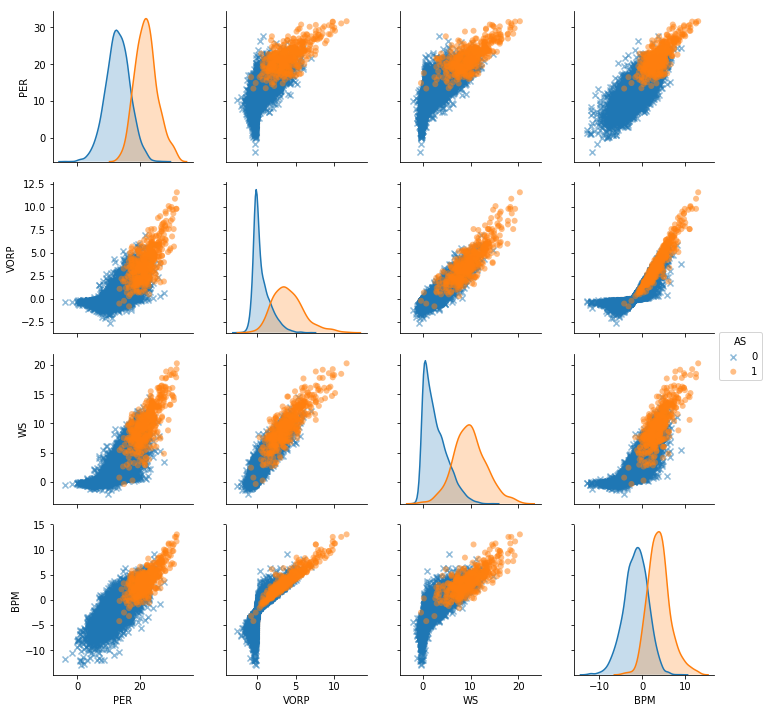

In [9]:
if includeadvancedstats:
    plotvariables = ['PER', 'VORP', 'WS', 'BPM']
else:
    plotvariables = ['PTS', 'eFG%', 'MP']

_ = sns.pairplot(df_training, vars=plotvariables, hue="AS",
                 diag_kind="kde", diag_kws=dict(shade=True),
                 markers = ['x','o'], plot_kws=dict(edgecolor="none", alpha=0.5))

Use Principal Component Analysis for dimensionality reduction and plot result:

--> Training data in the PCA1-PCA2 plane, where PCA1 and PCA2 represent the
    two principal axes in feature space of maximum variance in the data:


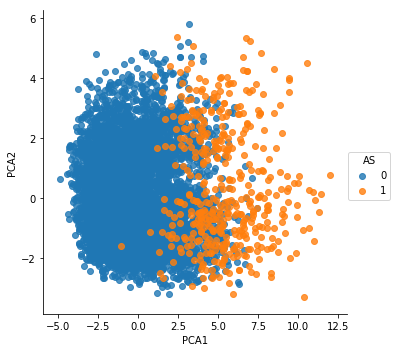

In [10]:
model = PCA(n_components=2, svd_solver='randomized') # Instantiate PCA model with hyperparameters

model.fit(X_training)                                # Fit model to data. Notice y is not specified!

X_2D = model.transform(X_training)                   # Transform the data to two dimensions

df_training['PCA1'] = X_2D[:, 0] 
df_training['PCA2'] = X_2D[:, 1]

print("--> Training data in the PCA1-PCA2 plane, where PCA1 and PCA2 represent the")
print("    two principal axes in feature space of maximum variance in the data:")

_ = sns.lmplot("PCA1", "PCA2", data=df_training, hue='AS', fit_reg=False)

Apply clustering algorithms to identify clusters in the training data and plot clusters:

--> KMeans clusters:


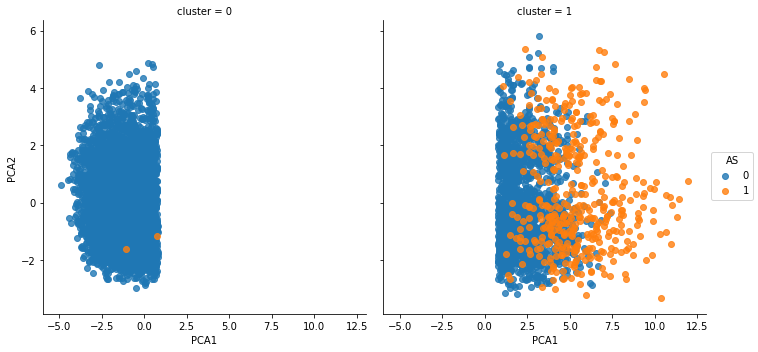

--> Gaussian Mixture clusters:


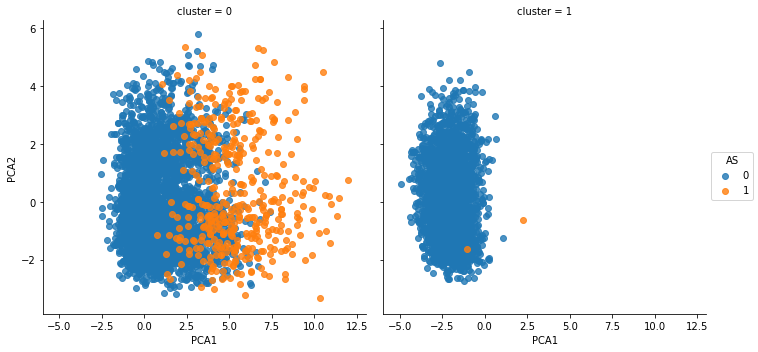

--> Spectral Clustering clusters:


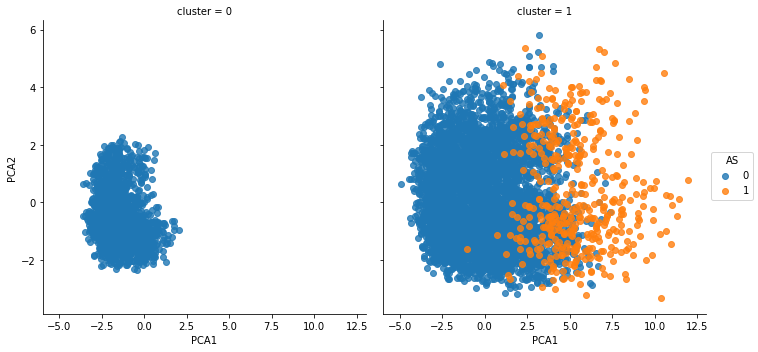

In [11]:
cluster_models = []

modelname = 'KMeans'
model = KMeans(n_clusters=2, init='random')                      # Instantiate model with hyperparameters
cluster_models.append((modelname, model))

modelname = 'Gaussian Mixture'
model = GaussianMixture(n_components=2, covariance_type='full')  # Instantiate model with hyperparameters
cluster_models.append((modelname, model))

modelname = 'Spectral Clustering'
model = SpectralClustering(n_clusters=2)                         # Instantiate model with hyperparameters
cluster_models.append((modelname, model))

for model in cluster_models:
                      
    model[1].fit(X_training)                                     # Fit model to data. Notice y is not specified!
    
    if hasattr(model[1], 'labels_'):                             # Determine cluster labels
        y_pred = model[1].labels_.astype(np.int)
    else:
        y_pred = model[1].predict(X_training)

    df_training['cluster'] = y_pred

    print("-->", model[0], "clusters:")
    sns.lmplot("PCA1", "PCA2", data=df_training, hue='AS', col='cluster', fit_reg=False)
    plt.show()

#### Unsupervised Learning Conclusion: 

Unfortunately the unsupervised algorithms tested above are unable to identify the NBA All-Stars as a clearly separate cluster amongst all NBA players. Therefore the analysis continues with the application of supervised algorithms.

## Supervised Learning: Classification

Select ML classifiers, set hyper-parameters and instantiate models:

In [12]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

mymodels   = []
modelnames = []

modelname = 'Logistic Regression Classifier' # 0
modelnames.append(modelname)
C = 100  # A smaller value for C results in more regularization (variance reduction due to noise in data)
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity)  => Feature selection, 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage) => Coefficient suppression
model = LogisticRegression(C=C, penalty=p)
mymodels.append(MyModel(modelname, model))

modelname = 'Nearest Neighbours Classifier' # 1 (CV is slowww)
modelnames.append(modelname)
n_n = 5
w   = 'uniform' # 'distance'
model = KNeighborsClassifier(n_neighbors=n_n, weights=w)
mymodels.append(MyModel(modelname, model))

#modelname = 'Support Vector Machine Classifier' # 2
modelname = 'Linear Support Vector Machine Classifier' # 2
modelnames.append(modelname)
#k = 'rbf' # 'linear' # 'poly', 'rbf'
#d = 3 # for kernel='poly'
C = 1
p = 'l2'
#model = SVC(kernel=k, degree=d, probability=True, C=C, random_state=rseed)
model = LinearSVC(C=C, penalty=p, dual=False)
mymodels.append(MyModel(modelname, model))

modelname = 'Stochastic Gradient Descent Classifier' # 3
modelnames.append(modelname)
l = 'hinge' # 'log', 'modified_huber', 'squared_hinge', 'perceptron'
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity), 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage)
model = SGDClassifier(loss=l, penalty=p, random_state=rseed)
mymodels.append(MyModel(modelname, model))

#modelname = 'Decision Tree Classifier' # 4
modelname = 'Bagged Decision Tree Classifier' # 4
modelnames.append(modelname)
m_d = None
m_f = 'auto'
#model = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
dtc = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, random_state=rseed)
model = BaggingClassifier(base_estimator=dtc, random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Random Forest Classifier' # 5
modelnames.append(modelname)
n_e = 100
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=sqrt(n_features) 
model = RandomForestClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Extremely Randomized Trees Classifier' # 6
modelnames.append(modelname)
n_e = 100
m_d = None
m_f = 'auto'
model = ExtraTreesClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Gradient Boost Classifier' # 7
modelnames.append(modelname)
n_e = 100
m_d = 3
l_l = 0.1
model = GradientBoostingClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_l, random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'AdaBoost Classifier' # 8
modelnames.append(modelname)
n_e = 100
l_l = 0.1
model = AdaBoostClassifier(n_estimators=n_e, learning_rate=l_l, random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Neural Network Classifier' # 9
modelnames.append(modelname)
a = 0.0001 # L2 penalty (regularization term) parameter
model = MLPClassifier(alpha=a, random_state=rseed)
mymodels.append(MyModel(modelname, model))

#modelname = 'Quadratic Discriminant Analysis Classifier' # 10
modelname = 'Linear Discriminant Analysis Classifier' # 10
modelnames.append(modelname)
#model = QuadraticDiscriminantAnalysis()
so = 'svd' # 'lsqr', 'eigen' (if 'svd', shrinkage should be None)
sh = None # 'auto' 
model = LinearDiscriminantAnalysis(solver=so, shrinkage=sh)
mymodels.append(MyModel(modelname, model))

'''
modelname = 'Gaussian Process Classifier'  # 11 (CV is slowwwwwwww)
modelnames.append(modelname)
model = GaussianProcessClassifier(random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Gaussian Naive Bayes Classifier' # 12 (Assumes Gaussian PDFs for feature distributions)
modelnames.append(modelname)
model = GaussianNB()
mymodels.append(MyModel(modelname, model))
'''

modelname = 'Passive Aggressive Classifier' # 13
modelnames.append(modelname)
C = 0.001
l = 'squared_hinge' # 'hinge'
model = PassiveAggressiveClassifier(C=C, loss=l, random_state=rseed)
mymodels.append(MyModel(modelname, model))

'''
modelname = 'Voting Classifier' # 14
modelnames.append(modelname)
classification_algs = []
for counter, mymodel in enumerate(mymodels, 1):
    #if (0 < counter < 10):
    clf_tuple = (mymodel.name, mymodel.classifier)
    classification_algs.append(clf_tuple)
    
model = VotingClassifier(estimators=classification_algs, voting='hard')
mymodels.append(MyModel(modelname, model))
'''

print("--> ML classifiers implemented in this analysis:")
print("")

for counter, mymodel in enumerate(mymodels, 1):
    print("{:2} : {}".format(counter, mymodel.name))
    #print("     Model parameters : ", mymodel.classifier.get_params())

--> ML classifiers implemented in this analysis:

 1 : Logistic Regression Classifier
 2 : Nearest Neighbours Classifier
 3 : Linear Support Vector Machine Classifier
 4 : Stochastic Gradient Descent Classifier
 5 : Bagged Decision Tree Classifier
 6 : Random Forest Classifier
 7 : Extremely Randomized Trees Classifier
 8 : Gradient Boost Classifier
 9 : AdaBoost Classifier
10 : Neural Network Classifier
11 : Linear Discriminant Analysis Classifier
12 : Passive Aggressive Classifier


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season, and calculate some model scores:

In [13]:
#note1 = " (Answers the question: How many predicted All-Stars are true All-Stars?)"
#note2 = " (Answers the question: How many true All-Stars have been predicted?)"
#note3 = " (i.e. the harmonic mean of Precision and Recall)"
#note4 = " (Answers the question: How many AS and non-AS have been correctly predicted?)"

logo = LeaveOneGroupOut()

scoring_list = ['precision', 'recall', 'f1', 'accuracy']

rts = True #False

cv_groups = df_training['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

cv_scores_list = []

for mymodel in mymodels:
    
    mymodel.reset()
    
    model     = mymodel.classifier
    modelname = mymodel.name

    print("--> Cross-validating", modelname, "...")
            
    cv_logo = logo.split(X_training, y_training, groups=cv_groups)

    scores = cross_validate(model, X_training, y_training, cv=cv_logo, scoring=scoring_list, return_train_score=rts); #, n_jobs=-1)

    print("    Total fit   time = {:5.1f} secs".format(scores['fit_time'  ].sum()))
    print("    Total score time = {:5.1f} secs".format(scores['score_time'].sum()))
    
    [mymodel.add_year_train_score(i)      for i in training_years          ] 
    [mymodel.add_precision_train_score(i) for i in scores['test_precision']]
    [mymodel.add_recall_train_score(i)    for i in scores['test_recall'   ]]
    [mymodel.add_f1_train_score(i)        for i in scores['test_f1'       ]]
    [mymodel.add_accuracy_train_score(i)  for i in scores['test_accuracy' ]]
    
    cv_scores_list.append({'Estimator'      : modelname, 
                           'Precision mean' : mymodel.precision_train_scores_mean .round(3)*100, 
                           'Precision std'  : mymodel.precision_train_scores_std  .round(3)*100, 
                           'Recall mean'    : mymodel.recall_train_scores_mean    .round(3)*100, 
                           'Recall std'     : mymodel.recall_train_scores_std     .round(3)*100, 
                           'F1 mean'        : mymodel.f1_train_scores_mean        .round(3)*100, 
                           'F1 std'         : mymodel.f1_train_scores_std         .round(3)*100, 
                           'Accuracy mean'  : mymodel.accuracy_train_scores_mean  .round(3)*100, 
                           'Accuracy std'   : mymodel.accuracy_train_scores_std   .round(3)*100})
    
    '''
    print("")
    print("--> Cross-val years  :", ["{:6d}".format(i) for i in mymodel.year_train_scores])
    print("")
    print("--> Precision scores :", ["{:6.1%}".format(i) for i in mymodel.precision_train_scores])
    print("--> Recall    scores :", ["{:6.1%}".format(i) for i in mymodel.recall_train_scores   ])
    print("--> F1        scores :", ["{:6.1%}".format(i) for i in mymodel.f1_train_scores       ])
    print("--> Accuracy  scores :", ["{:6.1%}".format(i) for i in mymodel.accuracy_train_scores ])
    print("")
    print("--> Precision score : {:5.1%} +/- {:5.1%}".format(mymodel.precision_train_scores_mean,
                                                             mymodel.precision_train_scores_std) + note1)
    print("--> Recall score    : {:5.1%} +/- {:5.1%}".format(mymodel.recall_train_scores_mean,
                                                             mymodel.recall_train_scores_std)    + note2)
    print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(mymodel.f1_train_scores_mean,
                                                             mymodel.f1_train_scores_std)        + note3)
    print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(mymodel.accuracy_train_scores_mean,
                                                             mymodel.accuracy_train_scores_std)  + note4)
    print("")
    '''

print("")
print("--> Cross-validation scores for all models (mean and std over all years):")
print("")

columnorder = ['Estimator', 'Precision mean', 'Precision std', 'Recall mean', 'Recall std', 
               'F1 mean', 'F1 std', 'Accuracy mean', 'Accuracy std']

df_cv_scores = pd.DataFrame(cv_scores_list, columns=columnorder)

display(HTML(df_cv_scores.to_html()))

--> Cross-validating Logistic Regression Classifier ...
    Total fit   time =   3.4 secs
    Total score time =   0.1 secs
--> Cross-validating Nearest Neighbours Classifier ...
    Total fit   time =   0.3 secs
    Total score time =   7.1 secs
--> Cross-validating Linear Support Vector Machine Classifier ...
    Total fit   time =   0.8 secs
    Total score time =   0.1 secs
--> Cross-validating Stochastic Gradient Descent Classifier ...
    Total fit   time =   0.2 secs
    Total score time =   0.1 secs
--> Cross-validating Bagged Decision Tree Classifier ...
    Total fit   time =   2.5 secs
    Total score time =   0.3 secs
--> Cross-validating Random Forest Classifier ...
    Total fit   time =  18.1 secs
    Total score time =   1.4 secs
--> Cross-validating Extremely Randomized Trees Classifier ...
    Total fit   time =  10.3 secs
    Total score time =   1.6 secs
--> Cross-validating Gradient Boost Classifier ...
    Total fit   time =  21.1 secs
    Total score time =   0.2

,Estimator,Precision mean,Precision std,Recall mean,Recall std,F1 mean,F1 std,Accuracy mean,Accuracy std
0,Logistic Regression Classifier,81.1,6.1,72.1,9.1,75.8,4.9,97.0,0.5
1,Nearest Neighbours Classifier,82.9,5.3,65.3,11.4,72.4,7.7,96.8,0.7
2,Linear Support Vector Machine Classifier,82.4,6.1,71.7,9.2,76.2,5.4,97.1,0.5
3,Stochastic Gradient Descent Classifier,79.0,11.6,69.2,11.8,72.4,5.8,96.6,0.8
4,Bagged Decision Tree Classifier,84.7,7.4,63.3,9.5,71.8,6.1,96.8,0.7
5,Random Forest Classifier,84.4,7.3,60.1,8.3,69.6,5.5,96.6,0.5
6,Extremely Randomized Trees Classifier,87.8,7.1,62.1,11.3,71.8,7.1,96.9,0.6
7,Gradient Boost Classifier,81.7,7.3,71.5,7.4,75.9,4.6,97.0,0.5
8,AdaBoost Classifier,82.9,6.6,66.1,10.5,73.0,7.4,96.9,0.7
9,Neural Network Classifier,80.8,6.4,70.4,10.4,74.6,5.8,96.9,0.6


 Calculate Receiver Operating Characteristic curves for all models:

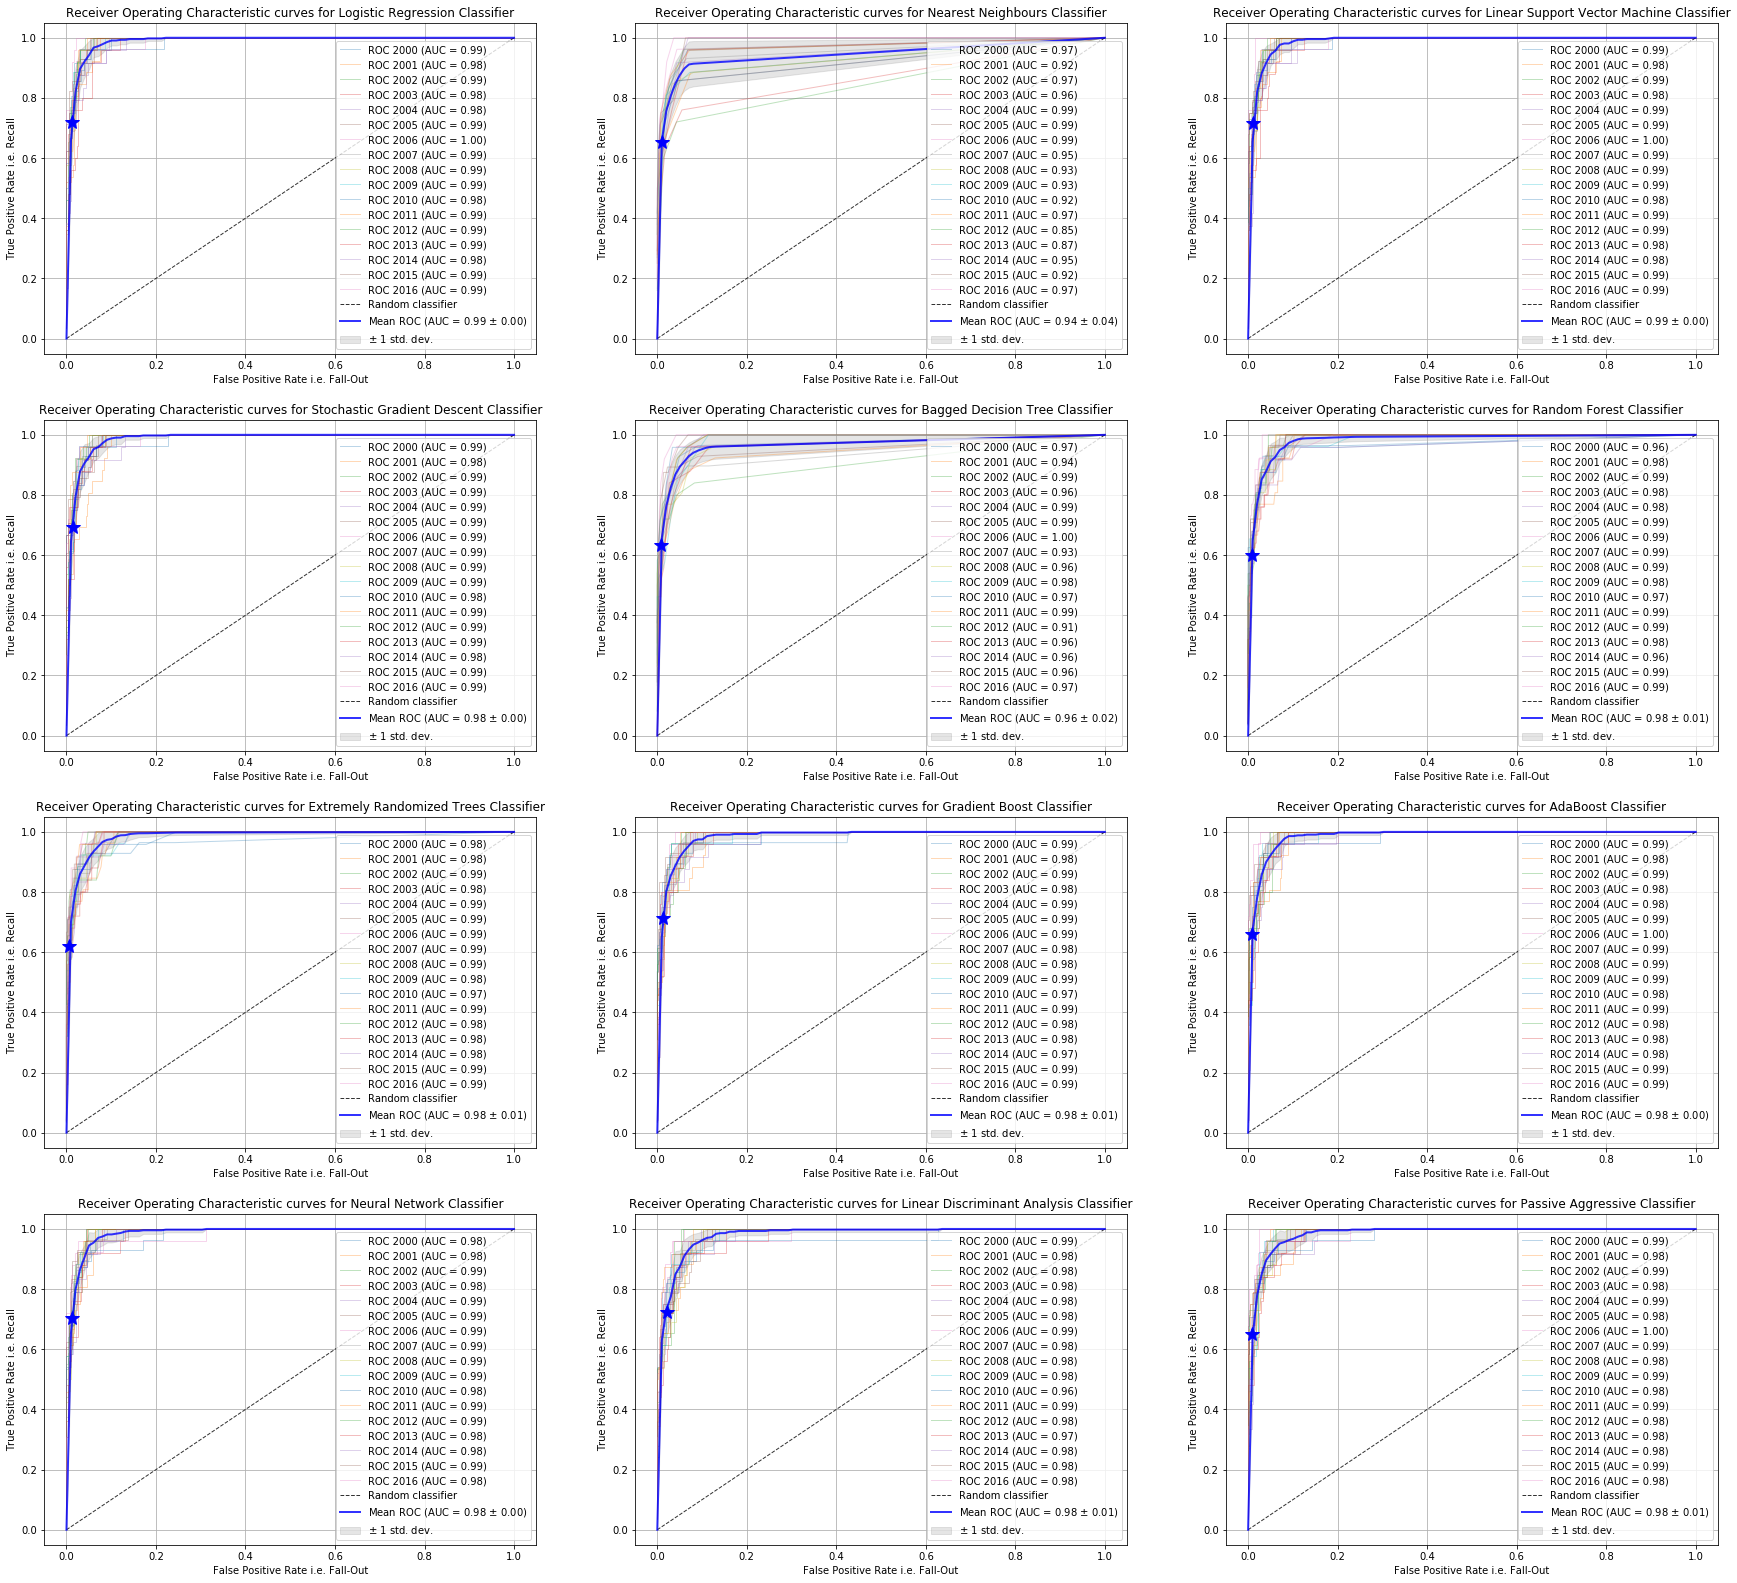

In [14]:
X_training = np.array(X_training) # To accommodate X_train = X_training[train_index] and X_test = X_training[test_index]
y_training = np.array(y_training) # To accommodate y_train = y_training[train_index] and y_test = y_training[test_index]

plt.figure(figsize=(30,28))

for imodel, mymodel in enumerate(mymodels):

    plt.subplot(4,3,imodel+1)
    
    model     = mymodel.classifier
    modelname = mymodel.name

    myTPRs = []
    myFPRs = []
    
    tprs = []
    roc_aucs = []
    mean_fprs = np.linspace(0, 1, 100)

    i = 0

    for train_index, test_index in logo.split(X_training, y_training, groups=cv_groups):

        training_year = training_years[i]
        i += 1
        
        X_train = X_training[train_index]
        X_test  = X_training[test_index]
        y_train = y_training[train_index]
        y_test  = y_training[test_index]
                       
        model.fit(X_train, y_train)
    
        y_model = model.predict(X_test)
        y_true = y_test.tolist()
        myCM = MyCM(confusion_matrix(y_true, y_model))
        myTPRs.append(myCM.tpr)
        myFPRs.append(myCM.fpr)
    
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
        else:
            y_score = model.decision_function(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        tprs.append(np.interp(mean_fprs, fpr, tpr))
        tprs[-1][0] = 0.0
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC {:d} (AUC = {:.2f})".format(training_year, roc_auc))
            
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    mean_myTPRs = np.mean(myTPRs, axis=0)
    mean_myFPRs = np.mean(myFPRs, axis=0)
    mymodel.add_mean_tpr(mean_myTPRs)
    mymodel.add_mean_fpr(mean_myFPRs)
    plt.plot(mean_myFPRs, mean_myTPRs, marker='*', color='blue', markersize=15)
    
    mean_tprs = np.mean(tprs, axis=0)
    mean_tprs[-1] = 1.0
    mean_roc_auc = auc(mean_fprs, mean_tprs)
    std_roc_auc = np.std(roc_aucs)
    mymodel.add_ROC_curve_data(mean_fprs, mean_tprs, mean_roc_auc, std_roc_auc)
    plt.plot(mean_fprs, mean_tprs, color='blue', lw=2, alpha=.8,
             label=r"Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})".format(mean_roc_auc, std_roc_auc))

    std_tprs = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
    tprs_lower = np.maximum(mean_tprs - std_tprs, 0)
    plt.fill_between(mean_fprs, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate i.e. Fall-Out")
    plt.ylabel("True Positive Rate i.e. Recall")
    plt.title("Receiver Operating Characteristic curves for " + modelname)
    plt.legend(loc='lower right')
    plt.grid(True)

 Calculate Precision-Recall curves for all models:

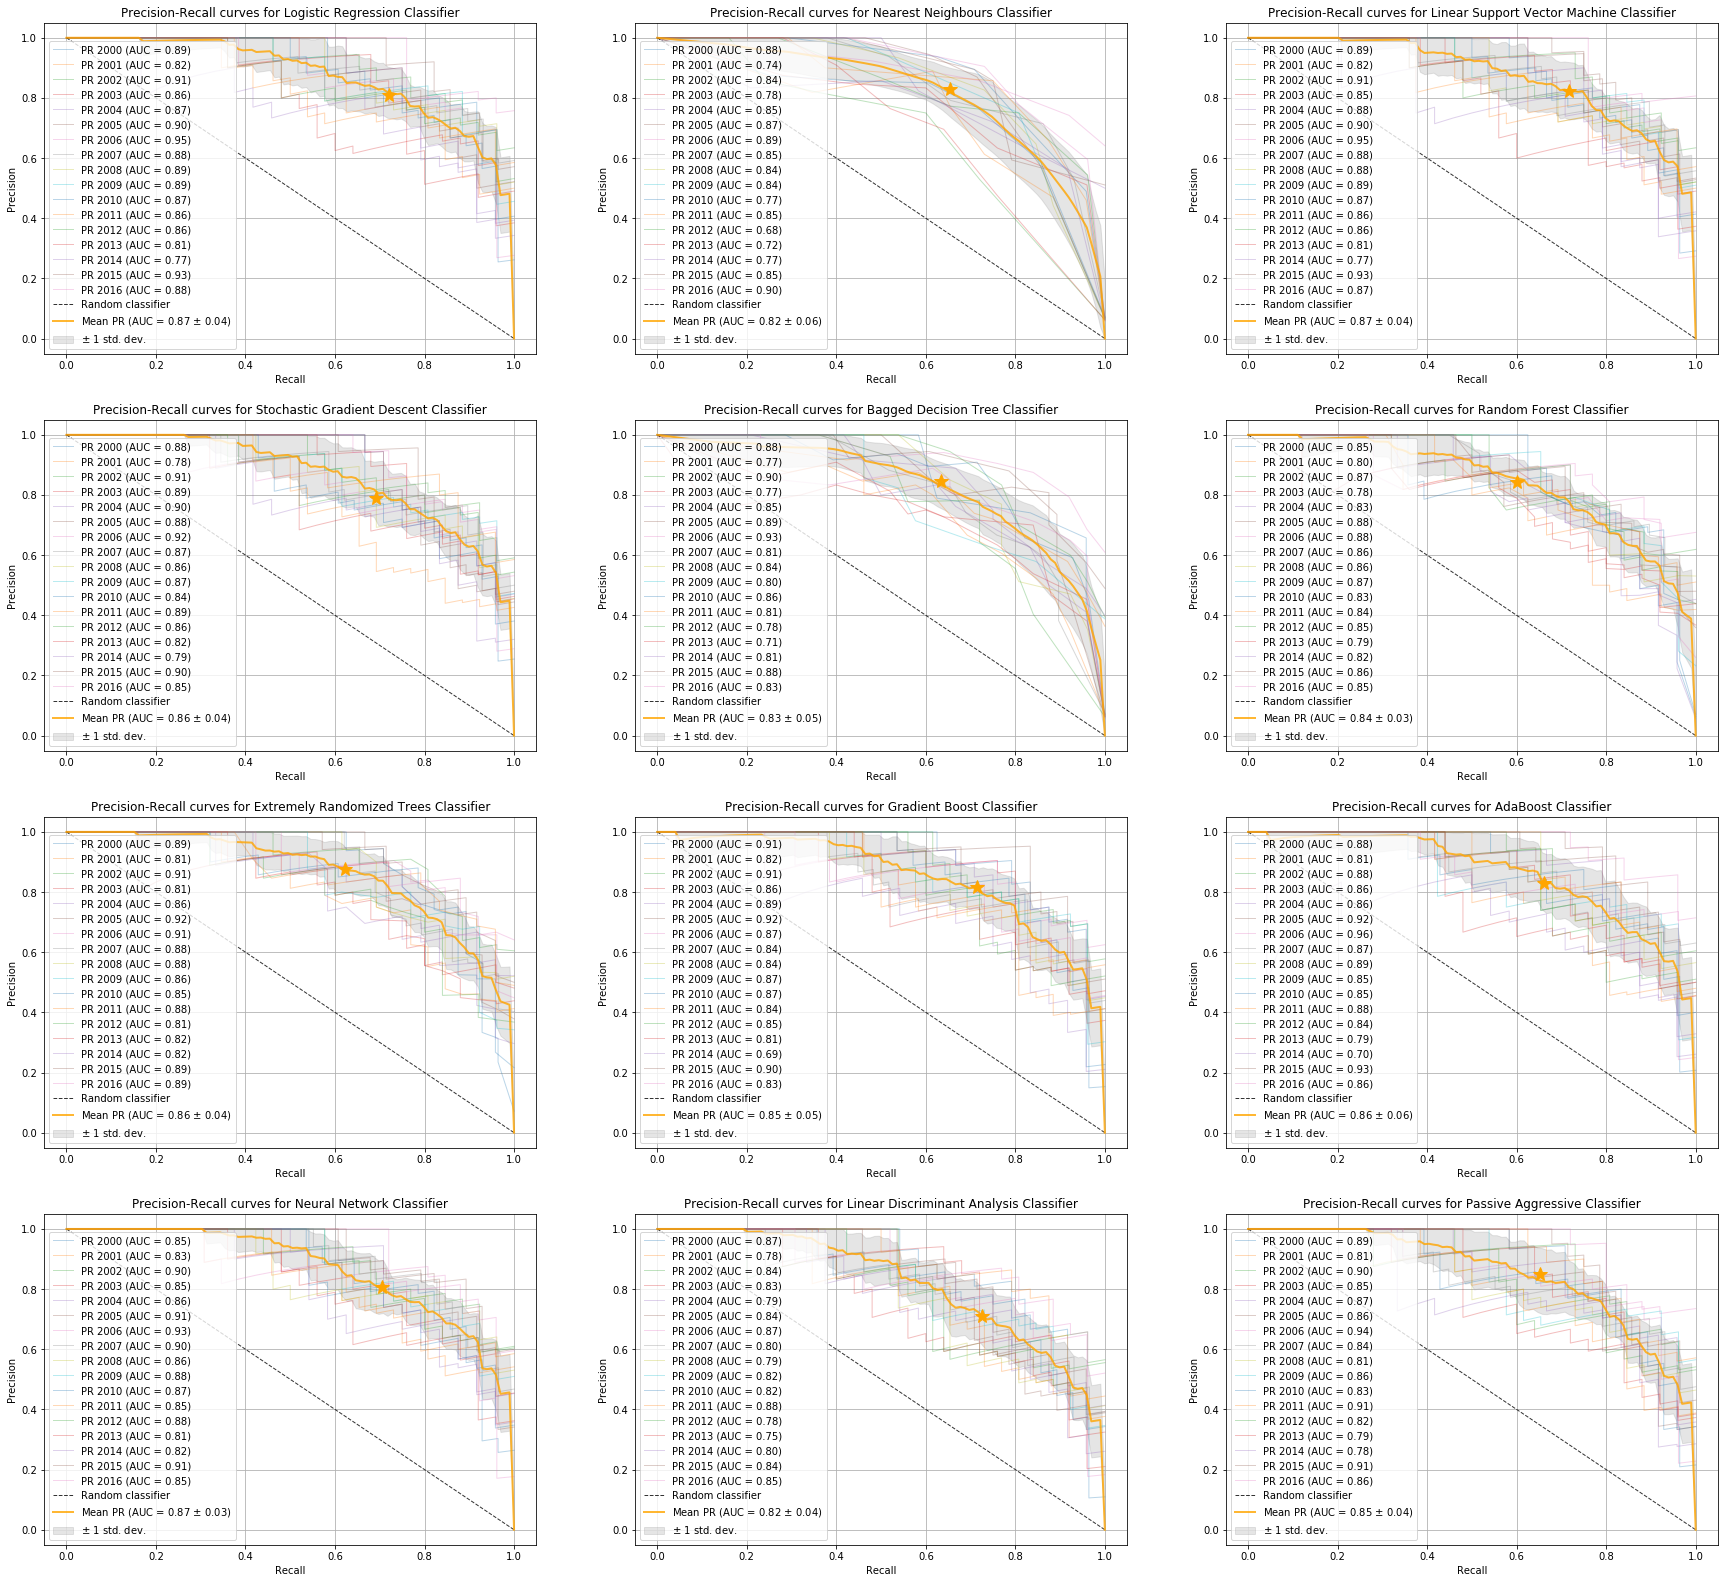

In [15]:
plt.figure(figsize=(30,28))

for imodel, mymodel in enumerate(mymodels):

    plt.subplot(4,3,imodel+1)
    
    model     = mymodel.classifier
    modelname = mymodel.name
    
    prs = []
    pr_aucs = []
    mean_rcs = np.linspace(0, 1, 100)

    i = 0

    for train_index, test_index in logo.split(X_training, y_training, groups=cv_groups):
        
        training_year = training_years[i]
        i += 1
        
        X_train = X_training[train_index]
        X_test  = X_training[test_index]
        y_train = y_training[train_index]
        y_test  = y_training[test_index]
                       
        model.fit(X_train, y_train)
        
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)
            pr, rc, thresholds = precision_recall_curve(y_test, y_score[:, 1])
        else:
            y_score = model.decision_function(X_test)
            pr, rc, thresholds = precision_recall_curve(y_test, y_score)
         
        pr_auc = auc(rc, pr)
        pr_aucs.append(pr_auc)
        rc = rc[::-1] # reverse list
        pr = pr[::-1] # reverse list
        prs.append(np.interp(mean_rcs, rc, pr))
        prs[-1][0] = 1.0
        plt.plot(rc, pr, lw=1, alpha=0.3, label="PR {:d} (AUC = {:.2f})".format(training_year, pr_auc))
        
    plt.plot([0, 1], [1, 0], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(mymodel.recall_train_scores_mean, mymodel.precision_train_scores_mean, 
             marker='*', color='orange', markersize=15)
    
    mean_prs = np.mean(prs, axis=0)
    mean_prs[-1] = 0.0
    mean_pr_auc = auc(mean_rcs, mean_prs)
    std_pr_auc = np.std(pr_aucs)
    mymodel.add_PR_curve_data(mean_prs, mean_rcs, mean_pr_auc, std_pr_auc)
    plt.plot(mean_rcs, mean_prs, color='orange', lw=2, alpha=.8,
             label=r"Mean PR (AUC = {:.2f} $\pm$ {:.2f})".format(mean_pr_auc, std_pr_auc))

    std_prs = np.std(prs, axis=0)
    prs_upper = np.minimum(mean_prs + std_prs, 1)
    prs_lower = np.maximum(mean_prs - std_prs, 0)
    plt.fill_between(mean_rcs, prs_lower, prs_upper, color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curves for " + modelname)
    plt.legend(loc="lower left")
    plt.grid(True)

Plot the mean ROC and PR curves for all models in single plots for comparison:

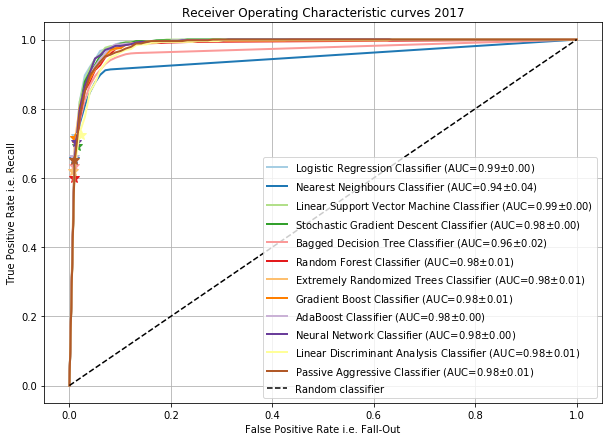

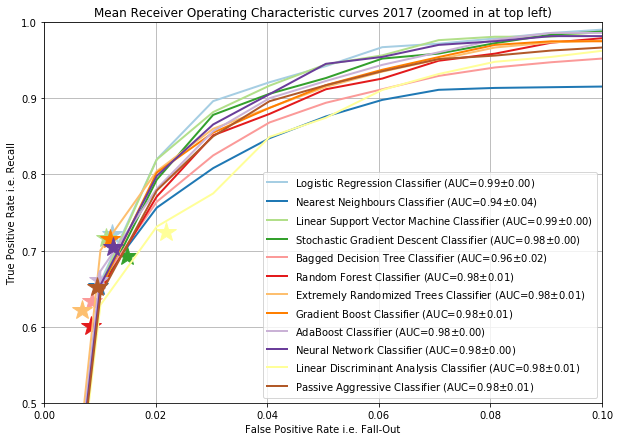

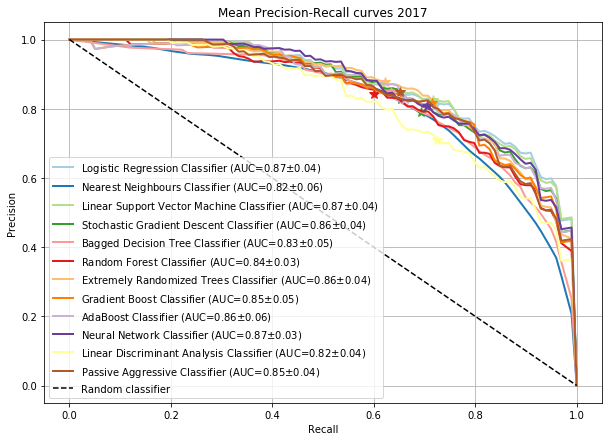

In [16]:
from matplotlib.pyplot import cm 
color=iter(cm.Paired(np.linspace(0,1,12))) #len(mymodels))))    

plt.figure(1, figsize=(10, 7))
plt.figure(2, figsize=(10, 7))
plt.figure(3, figsize=(10, 7))

#for mymodel in mymodels[:-1]: # Skip Voting Classifier: the predict_proba method is not available for 'hard' voting
for mymodel in mymodels:

    model     = mymodel.classifier
    modelname = mymodel.name

    c=next(color)
    
    plt.figure(1)
    plt.plot(mymodel.mean_fprs, mymodel.mean_tprs, color=c, lw=2,
             label='{} (AUC={:.2f}$\pm${:.2f})'.format(modelname, mymodel.mean_roc_auc, mymodel.std_roc_auc))
    plt.plot(mymodel.mean_fpr, mymodel.mean_tpr, marker='*', color=c, markersize=10)
    
    plt.figure(2)
    plt.plot(mymodel.mean_fprs, mymodel.mean_tprs, color=c, lw=2, 
             label='{} (AUC={:.2f}$\pm${:.2f})'.format(modelname, mymodel.mean_roc_auc, mymodel.std_roc_auc))
    plt.plot(mymodel.mean_fpr, mymodel.mean_tpr, marker='*', color=c, markersize=20)

    plt.figure(3)
    plt.plot(mymodel.mean_recall, mymodel.mean_precision, color=c, lw=2, 
             label='{} (AUC={:.2f}$\pm${:.2f})'.format(modelname, mymodel.mean_pr_auc, mymodel.std_pr_auc))
    plt.plot(mymodel.recall_train_scores_mean, mymodel.precision_train_scores_mean, marker='*', color=c, markersize=10)

plt.figure(1)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Receiver Operating Characteristic curves {}'.format(validation_year))
plt.legend(loc="lower right")
plt.grid(True)

plt.figure(2)
plt.xlim(0, 0.1)
plt.ylim(0.5, 1)
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Mean Receiver Operating Characteristic curves {} (zoomed in at top left)'.format(validation_year))
plt.legend(loc="lower right")
plt.grid(True)

plt.figure(3)
plt.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall curves {}'.format(validation_year))
plt.legend(loc="lower left")
plt.grid(True)

## Model training and predictions

Fit models to training data and use fitted models to predict test data from *prediction_year*:

In [17]:
scores_list = []

for mymodel in mymodels:
    
    model     = mymodel.classifier
    modelname = mymodel.name

    print("--> Fitting", modelname, "...")
    
    model.fit(X_training, y_training)  # Fit model to training data

    y_model = model.predict(X_prediction) # Predict test data
    mymodel.set_y_model(y_model)
    
    y_true = y_prediction.tolist()
    mymodel.set_y_true(y_true)
    
    CM = confusion_matrix(y_true, y_model) # defined as: rows -> truth, columns -> prediction

    mymodel.set_CM(CM)
    
    scores_list.append({'Estimator' : modelname, 
                        'TP'        : mymodel.CM.TP, 
                        'FP'        : mymodel.CM.FP, 
                        'FN'        : mymodel.CM.FN, 
                        'TN'        : mymodel.CM.TN, 
                        'Precision' : mymodel.CM.precision.round(3)*100, 
                        'Recall'    : mymodel.CM.recall.round(3)*100, 
                        'F1'        : mymodel.CM.f1.round(3)*100, 
                        'Accuracy'  : mymodel.CM.accuracy.round(3)*100,
                        'TPR'       : mymodel.CM.tpr.round(3)*100,
                        'FPR'       : mymodel.CM.fpr.round(3)*100})
    '''
    print("")
    print("--> Confusion matrix {}:".format(validation_year))
    print(CM)
    print("")

    TN = CM[0,0] # defined as: 0 = negative, 1 = positive
    FN = CM[1,0] # defined as: 0 = negative, 1 = positive
    FP = CM[0,1] # defined as: 0 = negative, 1 = positive
    TP = CM[1,1] # defined as: 0 = negative, 1 = positive

    TOT = TP + FP + FN + TN

    print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN , TN))
    print("")
    print("--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
    print("--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) = {:5.1%}".format(FP/(FP+TN)))
    print("")

    precision = precision_score(y_validation, y_model)
    recall    = recall_score   (y_validation, y_model)
    f1        = f1_score       (y_validation, y_model)
    accuracy  = accuracy_score (y_validation, y_model)
    
    print("--> Precision score (TP/(TP+FP)) : {:.1%}".format(precision) + note1)
    print("--> Recall score    (TP/(TP+FN)) : {:.1%}".format(recall   ) + note2)
    print("--> F1 score                     : {:.1%}".format(f1       ) + note3)
    print("--> Accuracy score ((TP+TN)/TOT) : {:.1%}".format(accuracy ) + note4)
    print("")
    '''

print("")
print("--> Prediction scores of all models for", prediction_year, ":")
print("")
    
columnorder = ['Estimator', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1', 'Accuracy', 'TPR', 'FPR']

df_scores = pd.DataFrame(scores_list, columns=columnorder)

display(HTML(df_scores.to_html()))

--> Fitting Logistic Regression Classifier ...
--> Fitting Nearest Neighbours Classifier ...
--> Fitting Linear Support Vector Machine Classifier ...
--> Fitting Stochastic Gradient Descent Classifier ...
--> Fitting Bagged Decision Tree Classifier ...
--> Fitting Random Forest Classifier ...
--> Fitting Extremely Randomized Trees Classifier ...
--> Fitting Gradient Boost Classifier ...
--> Fitting AdaBoost Classifier ...
--> Fitting Neural Network Classifier ...
--> Fitting Linear Discriminant Analysis Classifier ...
--> Fitting Passive Aggressive Classifier ...

--> Prediction scores of all models for 2018 :



,Estimator,TP,FP,FN,TN,Precision,Recall,F1,Accuracy,TPR,FPR
0,Logistic Regression Classifier,18,3,10,369,85.7,64.3,73.5,96.8,64.3,0.8
1,Nearest Neighbours Classifier,14,2,14,370,87.5,50.0,63.6,96.0,50.0,0.5
2,Linear Support Vector Machine Classifier,19,4,9,368,82.6,67.9,74.5,96.8,67.9,1.1
3,Stochastic Gradient Descent Classifier,21,8,7,364,72.4,75.0,73.7,96.2,75.0,2.2
4,Bagged Decision Tree Classifier,16,1,12,371,94.1,57.1,71.1,96.8,57.1,0.3
5,Random Forest Classifier,16,2,12,370,88.9,57.1,69.6,96.5,57.1,0.5
6,Extremely Randomized Trees Classifier,15,0,13,372,100.0,53.6,69.8,96.8,53.6,0.0
7,Gradient Boost Classifier,18,3,10,369,85.7,64.3,73.5,96.8,64.3,0.8
8,AdaBoost Classifier,17,2,11,370,89.5,60.7,72.3,96.8,60.7,0.5
9,Neural Network Classifier,18,4,10,368,81.8,64.3,72.0,96.5,64.3,1.1


Plot Confusion Matrices for all fitted models:

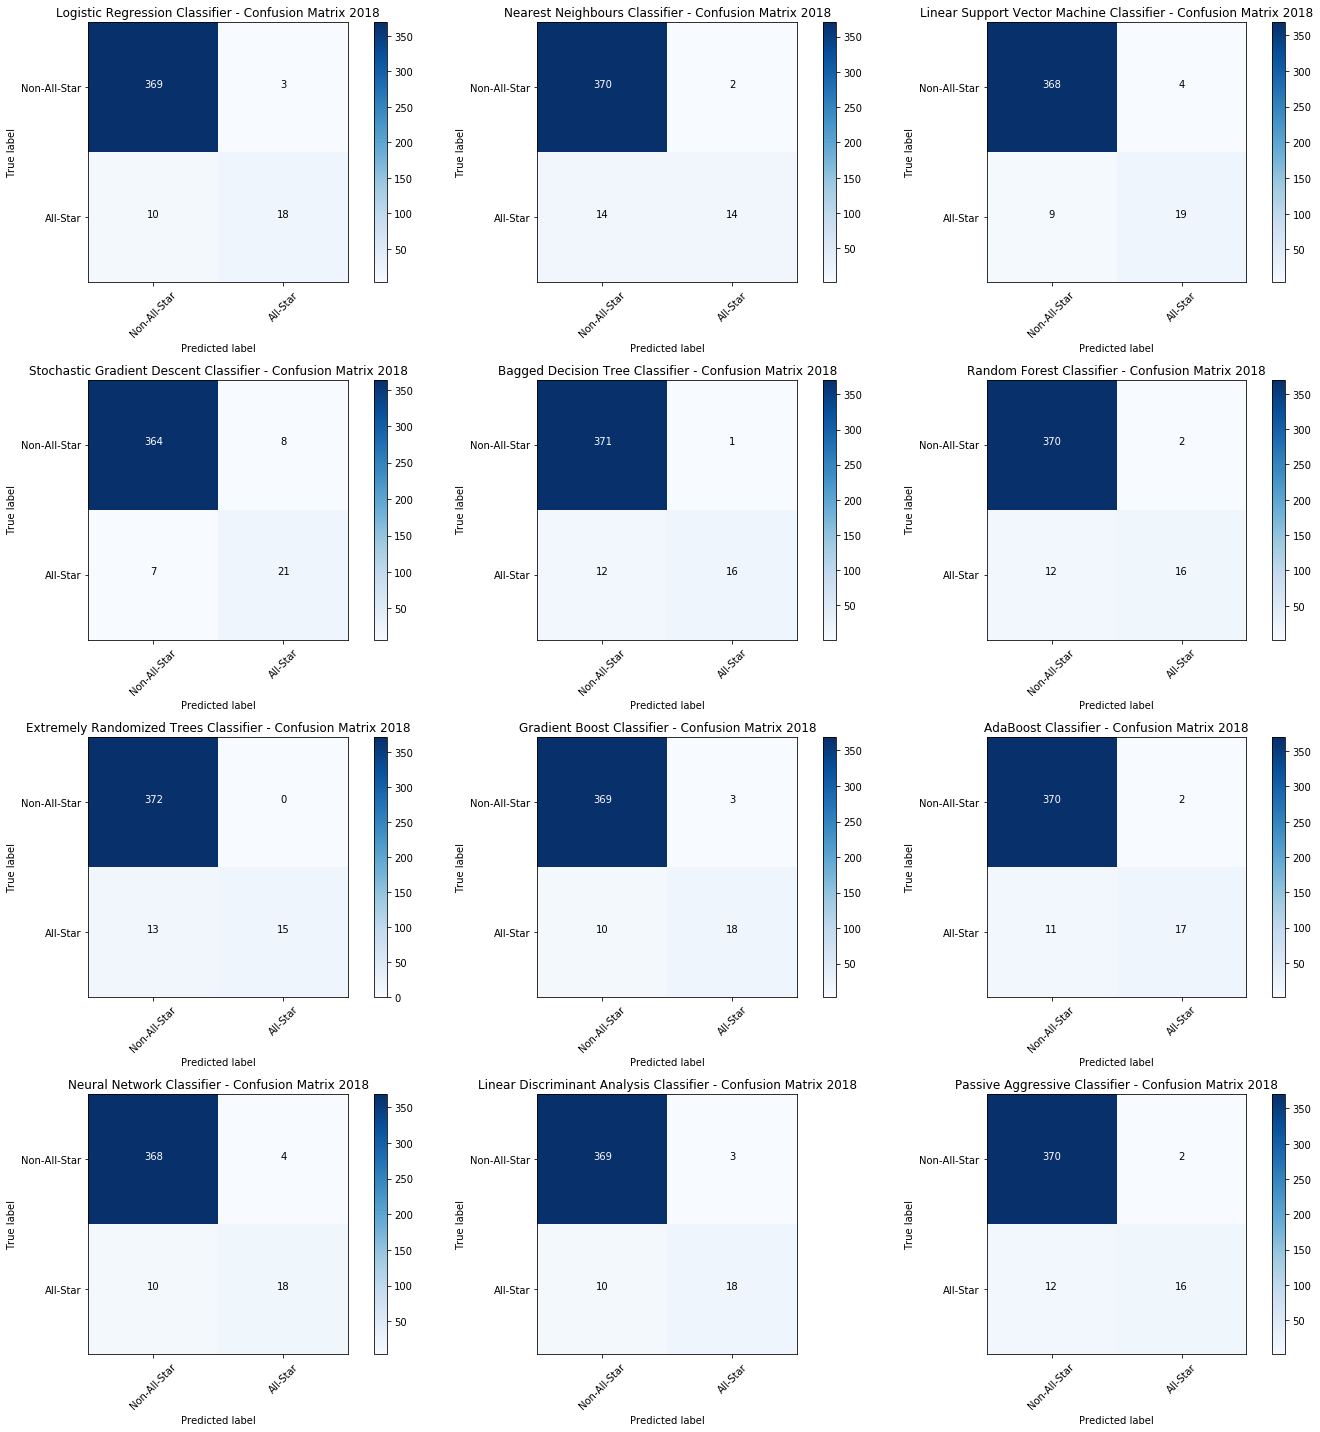

In [18]:
np.set_printoptions(precision=2)

class_names = ['Non-All-Star','All-Star']

plt.figure(figsize=(20,20))

for imodel, mymodel in enumerate(mymodels):

    plt.subplot(4,3,imodel+1)
    
    CM = confusion_matrix(mymodel.y_true, mymodel.y_model)

    NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names, normalize=False,
                                           title="{} - Confusion Matrix {}".format(mymodel.name, prediction_year))

Print classification reports for all fitted models:

Calculate feature importances of all fitted models (if applicable):

In [19]:
df_importances = pd.DataFrame(columns=modelnames, index=features)

for mymodel in mymodels:

    model     = mymodel.classifier
    modelname = mymodel.name

    print("--> Calculating feature importances for", modelname, "...")
    #print("")
    
    if hasattr(model, "feature_importances_"):
    
        importances = model.feature_importances_
        #indices = np.argsort(importances)[::-1]
    
        for i in range(X_training.shape[1]):
            #print("----> Feature importance ({:>2}) {:6} : {:.3f}".format(i + 1, features[indices[i]], importances[indices[i]]))
            df_importances.loc[features[i], modelname] = importances[i].round(3)*100
        
        #print("")
        
print("")
print("--> Feature importances of all models:")
print("")

display(HTML(df_importances.to_html()))

--> Calculating feature importances for Logistic Regression Classifier ...
--> Calculating feature importances for Nearest Neighbours Classifier ...
--> Calculating feature importances for Linear Support Vector Machine Classifier ...
--> Calculating feature importances for Stochastic Gradient Descent Classifier ...
--> Calculating feature importances for Bagged Decision Tree Classifier ...
--> Calculating feature importances for Random Forest Classifier ...
--> Calculating feature importances for Extremely Randomized Trees Classifier ...
--> Calculating feature importances for Gradient Boost Classifier ...
--> Calculating feature importances for AdaBoost Classifier ...
--> Calculating feature importances for Neural Network Classifier ...
--> Calculating feature importances for Linear Discriminant Analysis Classifier ...
--> Calculating feature importances for Passive Aggressive Classifier ...

--> Feature importances of all models:



,Logistic Regression Classifier,Nearest Neighbours Classifier,Linear Support Vector Machine Classifier,Stochastic Gradient Descent Classifier,Bagged Decision Tree Classifier,Random Forest Classifier,Extremely Randomized Trees Classifier,Gradient Boost Classifier,AdaBoost Classifier,Neural Network Classifier,Linear Discriminant Analysis Classifier,Passive Aggressive Classifier
G,NaN,NaN,NaN,NaN,NaN,0.9,1.6,1.2,0,NaN,NaN,NaN
GS/G,NaN,NaN,NaN,NaN,NaN,11.7,14.6,2.7,6,NaN,NaN,NaN
MP/G,NaN,NaN,NaN,NaN,NaN,12.7,9.2,7,11,NaN,NaN,NaN
3P,NaN,NaN,NaN,NaN,NaN,0.6,1,2.7,0,NaN,NaN,NaN
3PA,NaN,NaN,NaN,NaN,NaN,0.9,1,4.7,0,NaN,NaN,NaN
2P,NaN,NaN,NaN,NaN,NaN,5.2,8.3,5.8,0,NaN,NaN,NaN
2PA,NaN,NaN,NaN,NaN,NaN,4.3,7.9,3.1,0,NaN,NaN,NaN
FT,NaN,NaN,NaN,NaN,NaN,6.9,5.9,5.2,1,NaN,NaN,NaN
FTA,NaN,NaN,NaN,NaN,NaN,8.8,6.3,3.1,0,NaN,NaN,NaN
PF,NaN,NaN,NaN,NaN,NaN,1.3,1.3,4,5,NaN,NaN,NaN


Calculate feature coefficients of all fitted models (if applicable):

In [20]:
df_coefficients = pd.DataFrame(columns=modelnames, index=features)

for mymodel in mymodels:

    model     = mymodel.classifier
    modelname = mymodel.name

    print("--> Calculating feature coefficients for", modelname, "...")
    #print("")
    
    if hasattr(model, "coef_"):
    
        coefficients = model.coef_.ravel()
    
        #for feature_name, feature_coef in zip(features, coefficients):
        #    print("----> Model coefficient {:6} ({:2}) = {:>6.3f}".format(feature_name, counter, feature_coef))
        for i in range(X_training.shape[1]):
            df_coefficients.loc[features[i], modelname] = coefficients[i].round(2)
        
        #print("")
        
print("")
print("--> Feature coefficients of all models:")
print("")

display(HTML(df_coefficients.to_html()))

--> Calculating feature coefficients for Logistic Regression Classifier ...
--> Calculating feature coefficients for Nearest Neighbours Classifier ...
--> Calculating feature coefficients for Linear Support Vector Machine Classifier ...
--> Calculating feature coefficients for Stochastic Gradient Descent Classifier ...
--> Calculating feature coefficients for Bagged Decision Tree Classifier ...
--> Calculating feature coefficients for Random Forest Classifier ...
--> Calculating feature coefficients for Extremely Randomized Trees Classifier ...
--> Calculating feature coefficients for Gradient Boost Classifier ...
--> Calculating feature coefficients for AdaBoost Classifier ...
--> Calculating feature coefficients for Neural Network Classifier ...
--> Calculating feature coefficients for Linear Discriminant Analysis Classifier ...
--> Calculating feature coefficients for Passive Aggressive Classifier ...

--> Feature coefficients of all models:



,Logistic Regression Classifier,Nearest Neighbours Classifier,Linear Support Vector Machine Classifier,Stochastic Gradient Descent Classifier,Bagged Decision Tree Classifier,Random Forest Classifier,Extremely Randomized Trees Classifier,Gradient Boost Classifier,AdaBoost Classifier,Neural Network Classifier,Linear Discriminant Analysis Classifier,Passive Aggressive Classifier
G,0.6,NaN,-0.03,-14.44,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-0.02
GS/G,7.52,NaN,1.42,25.94,NaN,NaN,NaN,NaN,NaN,NaN,0.65,0.06
MP/G,4.37,NaN,0.96,23.83,NaN,NaN,NaN,NaN,NaN,NaN,-3.7,0.11
3P,1.04,NaN,0.32,4.57,NaN,NaN,NaN,NaN,NaN,NaN,2.08,-0.05
3PA,-1.57,NaN,-0.43,-0.04,NaN,NaN,NaN,NaN,NaN,NaN,-2.23,-0.05
2P,-0.66,NaN,-0.11,5.99,NaN,NaN,NaN,NaN,NaN,NaN,1.71,-0
2PA,-0.1,NaN,0.01,5.21,NaN,NaN,NaN,NaN,NaN,NaN,2.02,0.06
FT,0.42,NaN,0.12,3.27,NaN,NaN,NaN,NaN,NaN,NaN,1.15,0.03
FTA,-0.46,NaN,-0.11,1.54,NaN,NaN,NaN,NaN,NaN,NaN,1.39,0.05
PF,-1.04,NaN,-0.38,-7.14,NaN,NaN,NaN,NaN,NaN,NaN,-3.32,-0.28


Plot logistic curves for fitted Logistic Regression Classifier:

Check which players are All-Stars according to each fitted model:

In [21]:
for mymodel in mymodels:

    model     = mymodel.classifier
    modelname = mymodel.name

    y_model = mymodel.y_model
    y_true  = mymodel.y_true
    
    print("==> Checking which players are All-Stars in {} according to {} ...".format(prediction_year, modelname))
    print("")

    TN_players = []
    FP_players = []
    FN_players = []
    TP_players = []
    
    for i in range(len(y_model)):
    
        player_name = df_prediction.iat[i,0] # 0-th column in df is player name
    
        if ((y_true[i] == 0) and (y_model[i] == 0)):   # TN
            TN_players.append(player_name)
        elif ((y_true[i] == 0) and (y_model[i] == 1)): # FP
            FP_players.append(player_name)
        elif ((y_true[i] == 1) and (y_model[i] == 0)): # FN
            FN_players.append(player_name)
        else:                                          # TP
            TP_players.append(player_name)
        
    print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
    print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
    print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
    print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
    print("")
    print("--> Deserved true All-Stars:     ", TP_players)
    print("")
    print("--> Questionable true All-Stars: ", FN_players)
    print("")
    print("--> Snubbed non-All-Stars:       ", FP_players)
    print("")

==> Checking which players are All-Stars in 2018 according to Logistic Regression Classifier ...

--> # of     All-Stars predicted to be     All-Stars =  18 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  10 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   3 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 369 (TN)

--> Deserved true All-Stars:      ['LaMarcus Aldridge', 'Giannis Antetokounmpo', 'Jimmy Butler', 'DeMarcus Cousins', 'Stephen Curry', 'Anthony Davis', 'DeMar DeRozan', 'Andre Drummond', 'Kevin Durant', 'Joel Embiid', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Damian Lillard', 'Victor Oladipo', 'Karl-Anthony Towns', 'John Wall', 'Russell Westbrook']

--> Questionable true All-Stars:  ['Bradley Beal', 'Goran Dragic', 'Paul George', 'Draymond Green', 'Al Horford', 'Kevin Love', 'Kyle Lowry', 'Kristaps Porzingis', 'Klay Thompson', 'Kemba Walker']

--> Snubbed non-All-Stars:        ['Clint Capela', 'Nikola Jokic', 'Chris Paul']

==> Che

List all NBA players in *prediction_year* according to their model scores:

In [22]:
for mymodel in mymodels:

    model     = mymodel.classifier
    modelname = mymodel.name

    print("==> Model scores for top-50 players in {} according to {}:".format(prediction_year, modelname))
    print("")

    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_prediction)
    else:
        y_score = model.predict_proba(X_prediction)
    #y_score = model.predict_proba(X_prediction)
    
    player_score_dict = {}
    player_AS_dict    = {}

    if includeadvancedstats:
        AS_index = 51
    else:
        AS_index = 31
    
    for i in range(len(y_model)):

        player_name = df_prediction.iat[i,0]
        
        if hasattr(model, "decision_function"):
            player_score_dict[player_name] = y_score[i].ravel()[0]
        else:
            player_score_dict[player_name] = y_score[i].ravel()[1]
        #player_score_dict[player_name] = y_score[i].ravel()[1]
    
        if df_prediction.iat[i,AS_index] > 0.5:
            status = 'All-Star'
        else:
            status = 'Non-All-Star'
        player_AS_dict[player_name] = status
        
    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    counter = 0
    printed_line = False
    for key, value in dict(sorted_player_score_dict[:50]).items():
        counter += 1

        if hasattr(model, "decision_function"):
            if (value < 0 and not printed_line):
                print("**********************************************************")
                printed_line = True
        else:
            if (value < 0.5 and not printed_line):
                print("**********************************************************")
                printed_line = True

        #if (value < 0.5 and not printed_line):
        #    print("**********************************************************")
        #    printed_line = True
        print("----> {:3}: {:24} = {:.3f} ({})".format(counter, key, value, player_AS_dict[key]))
        
    print("")

==> Model scores for top-50 players in 2018 according to Logistic Regression Classifier:

---->   1: James Harden             = 7.837 (All-Star)
---->   2: Kevin Durant             = 5.805 (All-Star)
---->   3: LeBron James             = 5.804 (All-Star)
---->   4: Anthony Davis            = 5.419 (All-Star)
---->   5: Stephen Curry            = 4.959 (All-Star)
---->   6: Damian Lillard           = 4.112 (All-Star)
---->   7: Giannis Antetokounmpo    = 3.925 (All-Star)
---->   8: Russell Westbrook        = 3.675 (All-Star)
---->   9: Kyrie Irving             = 3.357 (All-Star)
---->  10: DeMarcus Cousins         = 2.487 (All-Star)
---->  11: LaMarcus Aldridge        = 2.413 (All-Star)
---->  12: Joel Embiid              = 2.261 (All-Star)
---->  13: Karl-Anthony Towns       = 1.744 (All-Star)
---->  14: Chris Paul               = 1.410 (Non-All-Star)
---->  15: Victor Oladipo           = 1.401 (All-Star)
---->  16: Jimmy Butler             = 0.810 (All-Star)
---->  17: DeMar DeRozan  

---->   1: Giannis Antetokounmpo    = 0.990 (All-Star)
---->   2: Anthony Davis            = 0.980 (All-Star)
---->   3: LeBron James             = 0.970 (All-Star)
---->   4: Russell Westbrook        = 0.970 (All-Star)
---->   5: Damian Lillard           = 0.910 (All-Star)
---->   6: DeMar DeRozan            = 0.880 (All-Star)
---->   7: LaMarcus Aldridge        = 0.870 (All-Star)
---->   8: James Harden             = 0.870 (All-Star)
---->   9: Kevin Durant             = 0.860 (All-Star)
---->  10: Victor Oladipo           = 0.840 (All-Star)
---->  11: Kyrie Irving             = 0.740 (All-Star)
---->  12: Jimmy Butler             = 0.710 (All-Star)
---->  13: Joel Embiid              = 0.660 (All-Star)
---->  14: Karl-Anthony Towns       = 0.620 (All-Star)
---->  15: Nikola Jokic             = 0.610 (Non-All-Star)
---->  16: DeMarcus Cousins         = 0.570 (All-Star)
---->  17: Bradley Beal             = 0.560 (All-Star)
---->  18: Blake Griffin            = 0.560 (Non-All-Star)
**

---->   1: James Harden             = 0.841 (All-Star)
---->   2: LeBron James             = 0.391 (All-Star)
---->   3: Russell Westbrook        = 0.388 (All-Star)
---->   4: Anthony Davis            = 0.357 (All-Star)
---->   5: Kevin Durant             = 0.351 (All-Star)
---->   6: Damian Lillard           = 0.344 (All-Star)
---->   7: Giannis Antetokounmpo    = 0.341 (All-Star)
---->   8: LaMarcus Aldridge        = 0.313 (All-Star)
---->   9: Victor Oladipo           = 0.290 (All-Star)
---->  10: Stephen Curry            = 0.284 (All-Star)
---->  11: Kyrie Irving             = 0.242 (All-Star)
---->  12: Joel Embiid              = 0.231 (All-Star)
---->  13: Jimmy Butler             = 0.207 (All-Star)
---->  14: Karl-Anthony Towns       = 0.207 (All-Star)
---->  15: Chris Paul               = 0.147 (Non-All-Star)
---->  16: DeMarcus Cousins         = 0.143 (All-Star)
---->  17: Andre Drummond           = 0.137 (All-Star)
---->  18: DeMar DeRozan            = 0.120 (All-Star)
----> 

Print prediction features of any particular player:

## Ensemble model

Create an ensemble model from ML classifier list using *VotingClassifier* with majority voting:

In [23]:
classification_algs = []

for counter, mymodel in enumerate(mymodels, 1):
    #if (0 < counter < 10):
    clf_tuple = (mymodel.name, mymodel.classifier)
    classification_algs.append(clf_tuple)
    
ensemble = VotingClassifier(estimators=classification_algs, voting='hard')

Cross-validate ensemble model:

In [24]:
cv_logo = logo.split(X_training, y_training, groups=cv_groups)

scores = cross_validate(ensemble, X_training, y_training, cv=cv_logo, scoring=scoring_list)
                                     
print("--> Cross-val years  :", ["{:6d}".format(yr) for yr in training_years])
print("")
print("--> Precision scores :", ["{:6.1%}".format(i) for i in scores['test_precision']])
print("--> Recall    scores :", ["{:6.1%}".format(i) for i in scores['test_recall'   ]])
print("--> F1        scores :", ["{:6.1%}".format(i) for i in scores['test_f1'       ]])
print("--> Accuracy  scores :", ["{:6.1%}".format(i) for i in scores['test_accuracy' ]])
print("")
print("--> Precision score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("--> Recall    score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_recall'   ]), np.std(scores['test_recall'   ])))
print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_f1'       ]), np.std(scores['test_f1'       ])))
print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_accuracy' ]), np.std(scores['test_accuracy' ])))

--> Cross-val years  : ['  2000', '  2001', '  2002', '  2003', '  2004', '  2005', '  2006', '  2007', '  2008', '  2009', '  2010', '  2011', '  2012', '  2013', '  2014', '  2015', '  2016']

--> Precision scores : ['100.0%', ' 76.0%', ' 94.7%', ' 89.5%', ' 79.2%', ' 86.4%', ' 84.6%', ' 77.8%', ' 81.0%', ' 88.2%', ' 88.9%', ' 81.8%', ' 93.3%', ' 77.8%', ' 76.2%', ' 94.7%', ' 85.7%']
--> Recall    scores : [' 58.3%', ' 73.1%', ' 69.2%', ' 68.0%', ' 79.2%', ' 79.2%', ' 88.0%', ' 72.4%', ' 65.4%', ' 57.7%', ' 57.1%', ' 75.0%', ' 56.0%', ' 56.0%', ' 66.7%', ' 64.3%', ' 69.2%']
--> F1        scores : [' 73.7%', ' 74.5%', ' 80.0%', ' 77.3%', ' 79.2%', ' 82.6%', ' 86.3%', ' 75.0%', ' 72.3%', ' 69.8%', ' 69.6%', ' 78.3%', ' 70.0%', ' 65.1%', ' 71.1%', ' 76.6%', ' 76.6%']
--> Accuracy  scores : [' 97.4%', ' 96.5%', ' 97.6%', ' 97.2%', ' 97.3%', ' 97.9%', ' 98.3%', ' 96.5%', ' 96.6%', ' 96.6%', ' 96.4%', ' 97.5%', ' 97.0%', ' 96.3%', ' 96.9%', ' 97.4%', ' 97.3%']

--> Precision score : 85.6% 

Check which players are All-Stars according to the ensemble model:

In [25]:
ensemble.fit(X_training, y_training)     # Fit ensemble to training data

y_model = ensemble.predict(X_prediction) # Use fitted ensemble on prediction data

y_true = y_prediction.tolist()

TN_players = []
FP_players = []
FN_players = []
TP_players = []
    
for i in range(len(y_model)):
    
    player_name = df_prediction.iat[i,0] # 0-th column in df is player name
    
    if ((y_true[i] == 0) and (y_model[i] == 0)):   # TN
        TN_players.append(player_name)
    elif ((y_true[i] == 0) and (y_model[i] == 1)): # FP
        FP_players.append(player_name)
    elif ((y_true[i] == 1) and (y_model[i] == 0)): # FN
        FN_players.append(player_name)
    else:                                          # TP
        TP_players.append(player_name)
        
print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
print("")
print("--> Deserved true All-Stars:     ", TP_players)
print("")
print("--> Questionable true All-Stars: ", FN_players)
print("")
print("--> Snubbed non-All-Stars:       ", FP_players)

--> # of     All-Stars predicted to be     All-Stars =  17 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  11 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   2 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 370 (TN)

--> Deserved true All-Stars:      ['LaMarcus Aldridge', 'Giannis Antetokounmpo', 'Jimmy Butler', 'DeMarcus Cousins', 'Stephen Curry', 'Anthony Davis', 'DeMar DeRozan', 'Andre Drummond', 'Kevin Durant', 'Joel Embiid', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Damian Lillard', 'Victor Oladipo', 'Karl-Anthony Towns', 'Russell Westbrook']

--> Questionable true All-Stars:  ['Bradley Beal', 'Goran Dragic', 'Paul George', 'Draymond Green', 'Al Horford', 'Kevin Love', 'Kyle Lowry', 'Kristaps Porzingis', 'Klay Thompson', 'Kemba Walker', 'John Wall']

--> Snubbed non-All-Stars:        ['Nikola Jokic', 'Chris Paul']


Check classification results per classifier in the ensemble model:

In [26]:
y_classification = ensemble.transform(X_prediction) # Class labels predicted per classifier in ensemble

player_scores_dict    = {}
player_sumscores_dict = {}
        
for i in range(len(X_prediction)):
    player_name         = df_prediction.iat[i,0]
    classification_list = y_classification[i]
    classification_sum  = np.sum(classification_list)
    player_scores_dict   [player_name] = classification_list
    player_sumscores_dict[player_name] = classification_sum

sorted_player_sumscores_dict = sorted(player_sumscores_dict.items(), key=operator.itemgetter(1), reverse=True)

print("--> Sum of ML classifiers for top-50 players in {}:".format(prediction_year))
print("")

counter = 0
printed_line = False
for key, value in dict(sorted_player_sumscores_dict[:50]).items():
    counter += 1
    if (value < 5 and not printed_line):
        print("*****************************************************************************")
        printed_line = True
    print("----> {:3}: {:24} = {:d} {} ({})".format(counter, key, value, player_scores_dict[key], player_AS_dict[key]))

--> Sum of ML classifiers for top-50 players in 2018:

---->   1: Giannis Antetokounmpo    = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   2: Jimmy Butler             = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   3: Anthony Davis            = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   4: DeMar DeRozan            = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   5: Kevin Durant             = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   6: Joel Embiid              = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   7: James Harden             = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   8: LeBron James             = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   9: Damian Lillard           = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->  10: Karl-Anthony Towns       = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->  11: Russell Westbrook        = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->  12: LaMarcus Aldridge        = 8 [1 0 1 1 1 1 1 1 1] (All-Star)
---->  13: Kyrie Irving             = 8 [1 0 1 1 1 1 1 1 1] (All-Star)
---->  14: Victor Olad

#### Supervised Learning Conclusion: 

The supervised algorithms are able to predict the NBA All-Stars with reasonably good precision and recall.